In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

In [347]:
coef = np.load('coef.npy')
print(coef[0:5])
print(coef.shape)

[ 0.00388722  0.          0.         -0.0059821   0.        ]
(601,)


In [348]:
features_df = pd.read_csv("features_binned.csv")
features_df = features_df.drop(columns=["Unnamed: 0"])
cols = features_df.columns
cols

Index(['+ve strand', 'pos_-27_A', 'pos_-27_C', 'pos_-27_G', 'pos_-27_T',
       'pos_-26_A', 'pos_-26_C', 'pos_-26_G', 'pos_-26_T', 'pos_-25_A',
       ...
       'AG_comp_0.9', 'AG_comp_1.0', 'length_18', 'length_19', 'length_20',
       'length_21', 'length_22', 'length_23', 'length_24', 'length_25'],
      dtype='object', length=601)

In [349]:
cols = np.array(cols)
cols = cols.reshape(cols.shape[0])

In [423]:
def set_graph(first, ax):
    ax.spines['left'].set_visible(first)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if not first:
        ax.set_yticks([])

In [439]:
def plot_TSS(ax, first):
    dist_indices = ['dist' in colname for index, colname in enumerate(cols)]
    dist_coef = np.array(coef[dist_indices]).reshape(2,2)
    df = pd.DataFrame(dist_coef,
                     index=['Primary', 'Secondary'],
                     columns=pd.Index(['Downstream', 'Upstream'])) 

    df.plot(ax=ax, kind='bar',figsize=(10,4), color = ['w','slategrey'], edgecolor='k', fontsize=14)
    set_graph(first, ax)
    ax.set_ylim((-0.1, 0.1))
    ax.legend(fontsize=14)
    ax.title.set_text('Distance to TSS')

In [435]:
def plot_strand(ax, first):
    dist_indices = ['+ve' in colname for index, colname in enumerate(cols)]
    dist_name = cols[dist_indices]
    dist_coef = coef[dist_indices]
    ax.bar('sense strand', dist_coef, color = 'slategrey',  edgecolor='k')
    ax.set_ylim((-0.1, 0.1))
    ax.set_xlim((-5, 5))
    set_graph(first, ax)
    ax.title.set_text('Strand Targeted')

In [436]:
def get_run(string):
    return int(re.findall('[0-9]+', string)[0])

In [440]:
def plot_length(ax, first):
    dist_indices = ['length' in colname for index, colname in enumerate(cols)]
    dist_name = cols[dist_indices]
    dist_coef = coef[dist_indices]
    dist = [get_run(name) for name in dist_name]
    ax.bar(dist[1:], dist_coef[1:], color = 'slategrey',  edgecolor='k')
    ax.set_ylim((-0.1, 0.1))
    ax.set_xticks(dist[1:])
    set_graph(first, ax)
    ax.title.set_text('Length of sgRNA')

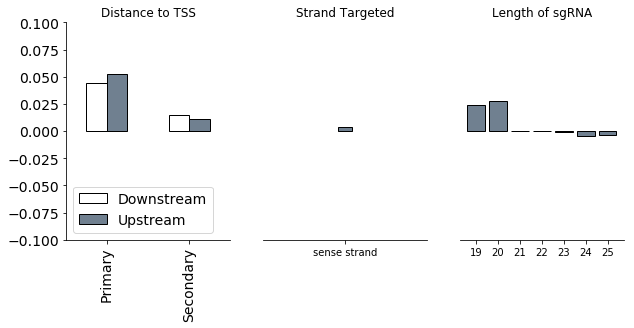

In [466]:
fig, axs = plt.subplots(1, 3, figsize=(10, 5))
plot_TSS(axs[0], True)
plot_strand(axs[1], False)
plot_length(axs[2], False)

In [352]:
# Regular expression which returns a boolean if the column name is for a nucleotide position
def find_nucl_pos(string):
    prog = re.compile('pos_-[0-9]+_[A-Z]$')
    result = prog.match(string)
    return bool(result)

In [353]:
# Regular expression which returns a boolean if the column name is for a dimer position
def find_dimer_pos(string):
    prog = re.compile('pos_-[0-9]+_[A-Z][A-Z]$')
    result = prog.match(string)
    return bool(result)

In [354]:
nucl_pos_bool = [find_nucl_pos(name) for name in cols]
dimer_pos_bool = [find_dimer_pos(name) for name in cols]

In [355]:
def get_pos(string):
    return -1 * int(re.findall('[0-9]+', string)[0])

In [356]:
# Extract out position elements
nucl_pos_names = cols[nucl_pos_bool]
nucl_pos = [get_pos(name) for name in nucl_pos_names]

dimer_pos_names = cols[dimer_pos_bool]
dimer_pos = [get_pos(name) for name in dimer_pos_names]

In [357]:
nucl_coef = coef[nucl_pos_bool]
dimer_coef = coef[dimer_pos_bool]

In [358]:
def specific_nucl_pos(nucleotide):
    pos_bool = [nucleotide in name for name in nucl_pos_names]
    names = nucl_pos_names[pos_bool]
    pos = [get_pos(name) for name in names]
    coef = nucl_coef[pos_bool]
    return (names, pos, coef)

In [359]:
A = specific_nucl_pos('A')
C = specific_nucl_pos('C')
G = specific_nucl_pos('G')
T = specific_nucl_pos('T')
nucl_pos_plot = [A, C, G, T]

In [360]:
from matplotlib.pyplot import figure

In [457]:
def pos_plot(plot_info, colors, title, legend, ax):
    width = 1/len(plot_info)
    for index, nucl in enumerate(plot_info):
        ax.bar(np.array(nucl[1]) + (index - 1)*width, nucl[2] + 0.0003, width, color = colors[index])

    ax.legend(legend)
    ax.set_xticks((-1 * np.arange(len(nucl[1])) - 3))
    ax.set_ylim((-0.1, 0.1))
    ax.title.set_text(title)

In [363]:
def specific_dimer_pos(dimer):
    pos_bool = [dimer in name for name in dimer_pos_names]
    names = dimer_pos_names[pos_bool]
    pos = [get_pos(name) for name in names]
    curr_coef = dimer_coef[pos_bool]
    return (names, pos, curr_coef)

In [364]:
dimer_encodings = {'AA' : 0, 'AC' : 1, 'AG' : 2, 'AT' : 3, 'CA' : 4, 'CC' : 5, 'CG' : 6, 'CT' : 7,          
                   'GA' : 8, 'GC' : 9, 'GG' : 10, 'GT' : 11, 'TA' : 12, 'TC' : 13, 'TG' : 14, 'TT' : 15}
dimers = dimer_encodings.keys()
dimer_plot = []
for dimer in dimers:
    dimer_plot.append(specific_dimer_pos(dimer))

Note: they label the big ones with the dimer name

Program? Adobe? 

color blind palette?? 

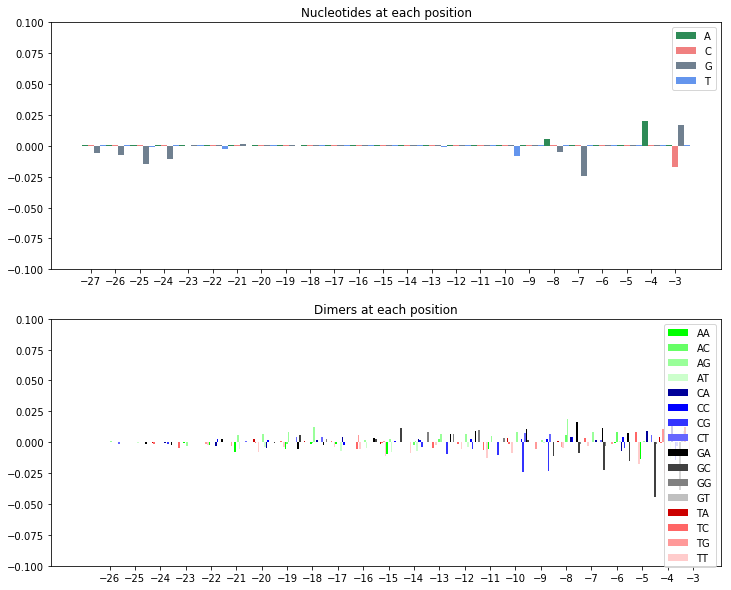

In [463]:
f, axs = plt.subplots(2, 1,figsize=(12,10))
colors =  ['seagreen', 'lightcoral', 'slategrey', 'cornflowerblue']
pos_plot(nucl_pos_plot, colors, "Nucleotides at each position", ('A', 'C', 'G', 'T'), axs[0])
colors = ['#00FF00', '#66FF66', '#99FF99', '#CCFFCC',
         '#000099', '#0000FF', '#3333FF','#6666FF',
         '#000000', '#404040', '#808080', '#C0C0C0',
         '#CC0000', '#FF6666', '#FF9999', '#FFCCCC']
pos_plot(dimer_plot, colors,"Dimers at each position", dimers, axs[1])

In [411]:
def longest_run(nucl, ax, color, first):
    dist_indices = ['longest_' + nucl in colname for index, colname in enumerate(cols)]
    dist_name = cols[dist_indices]
    dist_coef = coef[dist_indices]
    dist = [get_run(name) for name in dist_name]
    ax.bar(dist[1:], dist_coef[1:], color = color, edgecolor='k')
    ax.set_ylim((-0.1, 0.1))
    set_graph(first, ax)
    ax.title.set_text('Longest consecutive run of ' + nucl)

In [412]:
def composition(nucl, ax, color, first):
    dist_indices = [nucl + '_comp' in colname for index, colname in enumerate(cols)]
    dist_name = cols[dist_indices]
    dist_coef = coef[dist_indices]
    dist = [name[-3:] for name in dist_name]
    ax.bar(dist, dist_coef + 0.001, color = color, edgecolor='k')
    ax.set_ylim((-0.1, 0.1))
    set_graph(first, ax)
    ax.title.set_text('Composition of ' + nucl)

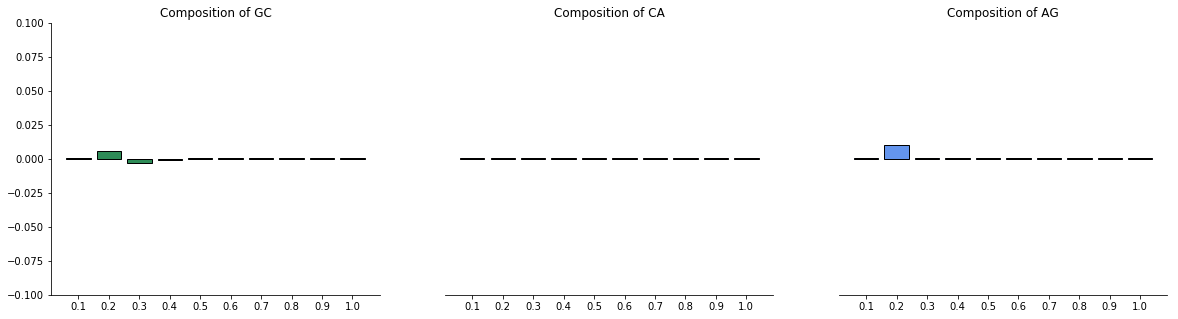

In [373]:
f, axs = plt.subplots(1,3,figsize=(20,5))
colors = ['seagreen', 'lightcoral', 'cornflowerblue']
for nucl, ax, color in [('GC', axs[0], colors[0]), 
                ('CA', axs[1], colors[1]),
                ('AG', axs[2], colors[2])]:
    if(ax == axs[0]):
        composition(nucl, ax, color, True)
    else:
        composition(nucl, ax, color, False)
    
# hide outer axes 
for ax in axs.flat:
    ax.label_outer()


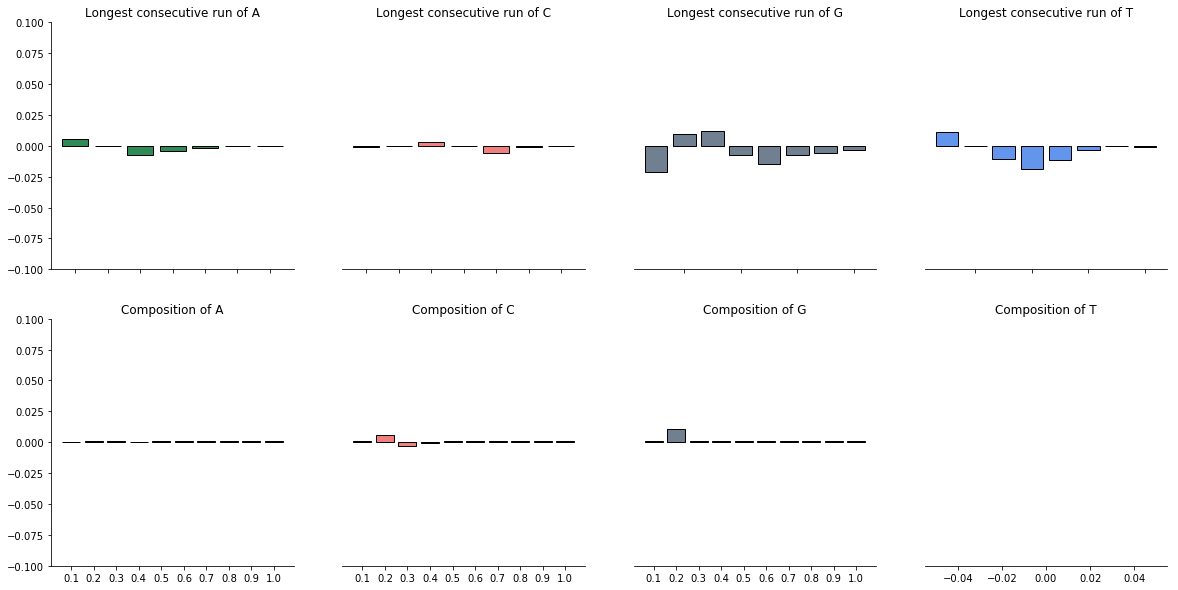

In [464]:
f, axs = plt.subplots(2,4,figsize=(20,10))

colors = ['seagreen', 'lightcoral', 'slategrey', 'cornflowerblue']
for nucl, ax_run, ax_comp, color in [('A', axs[0, 0], axs[1, 0], colors[0]), 
                ('C', axs[0, 1], axs[1, 1], colors[1]),
                ('G', axs[0, 2], axs[1, 2], colors[2]),
                ('T', axs[0, 3], axs[1, 3], colors[3])]:
    if(ax_run == axs[0, 0]):
        longest_run(nucl, ax_run, color, True)
        composition(nucl, ax_comp, color, True)
    else:
        longest_run(nucl, ax_run, color, False)
        composition(nucl, ax_comp, color, False)

# hide outer axes 
for ax in axs.flat:
    ax.label_outer()